<a href="https://colab.research.google.com/github/andrew-veriga/MathForML/blob/master/ConvolutionalCoffieCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [1]:
import tensorflow as tf
import numpy as np

### Load picture

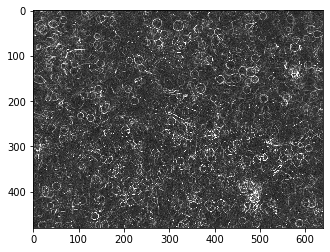

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path='https://github.com/andrew-veriga/MathForML/blob/master/CoffieCircles.png?raw=true'
Image = mpimg.imread(img_path)
plt.imshow(Image)

In [3]:
print(Image.shape)

(480, 640, 4)


###Prepare picture
Convert Image to 2D

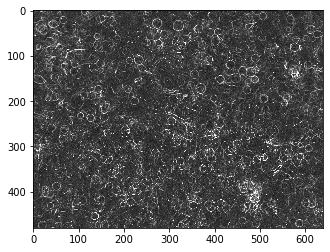

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Image = rgb2gray(Image)    
plt.imshow(Image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [5]:
print (Image.shape)

(480, 640)


###Init variables

`MaxSize` - max size of square region

`MinSize` - min size of square region

`Contrast` - scalar set contrast of recognizing ring 
`Thick` - thickness of ring
`FoundCircles` - numpy array of centers and radiuces (3,None)

In [0]:
firstX=1
firstY=1
ImageSize = (48,90) #Image.shape
MaxSize = 40 
MinSize = 10
Contrast = 2.
Variance = 0.03
Thick = .8
FoundCircles = np.array([0,3])
_DEBUG_=False

In [0]:
# from scipy.spatial import distance
# for i in range(0,a.shape[0]):
#   d = [np.sum((a[i]-a[j])**2) for j in range(i+1,a.shape[0])] 
#   print(d) 

###function isCircleFound
calculate average brightness over all pixels of current square;
If pixels of SelectedRing have avg brightness more then avg brightness over all square - circle is found 


In [0]:
#from scipy.special import softmax

def isCircleFound(_box, _mask, _backmask):
  background = np.logical_xor(_backmask, _mask)  
  bias = np.min(_box)
  brightness = (lambda arr: np.percentile(arr-bias,90))#/(np.max(arr)-np.min(box))))
  if _DEBUG_:

    print ('ring brightness', brightness(_box[_mask]))
    print ('back brightness', brightness(_box[background]))
    print('ring.var', np.var(_box[_mask]-bias))
    print('full.var', np.var(_box-bias))
    print('back.var', np.var(_box[background]-bias))
  return ((brightness(_box[_mask]) / brightness(_box[background])) /np.var(_box[_mask]))#/np.var(_box[~_mask]) < 1)
  

###function getMask
create square matrix of boolean as a ring of Trues inscribed in a square of Falses

ring brightness 0.4940682579942046
back brightness 0.4297609677095717
ring.var 0.03323687470393825
full.var 0.019979368829408546
back.var 0.025380246998330143
34.5891431904949


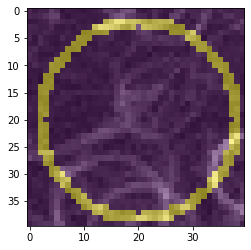

In [9]:
import itertools

def getMask( size, thick = 1 ):
    radius = size /2 - 2
    center = np.array([size/2,size/2])
    vectors = [[(i,j) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: np.abs(np.linalg.norm(v - center) - radius) < thick,l)))
    # print(selectedVecs)
    #ring mask
    ring = np.array(np.zeros((size,size),dtype=np.bool))
    
    for (i,j) in (selectedVecs):
      ring[i,j]=True
    
    return ring

square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
Mask=getMask(MaxSize,1) 
backMask=getMask(MaxSize,2) 
#ring visualisation
fig, ax = plt.subplots()
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax.imshow(Mask,alpha=.5)
fig.show()
_DEBUG_=True
print (isCircleFound(square, Mask, backMask))
_DEBUG_=False

##function RotateConv

In [0]:
import cv2
# https://issue.life/questions/43892506/
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape # image shape has 2 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    # rotation_mat[0, 2] += bound_w/2 - image_center[0]
    # rotation_mat[1, 2] += bound_h/2 - image_center[1]
    # rotation_mat[0, 2] += bound_w/2 - image_center[0]
    # rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (width, height))
    return rotated_mat
  

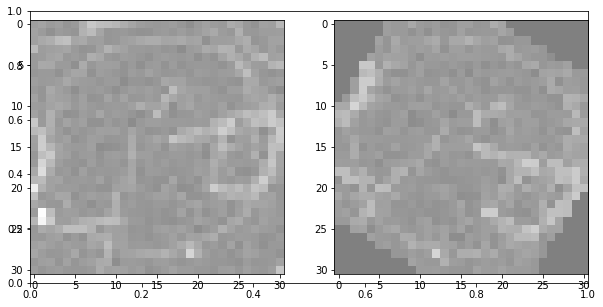

In [11]:
  import math
  _angle = np.pi / 6
  (size, x,y) = (31,151,67)
  _box = Image[y:y+size, x:x+size]
# def RotateConv(_box,_angle):
  size = _box.shape[0]
  center = np.array([size//2,size//2],dtype=np.int)
  coords = np.indices((size, size)).reshape(2, -1)
  coords=np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int)
  
  R_mat = np.array([
    [np.cos(_angle), np.sin(_angle), 0],
    [-np.sin(_angle), np.cos(_angle), 0],
    [0, 0, 1]
  ])
  T = np.array([
    [1, 0, center[1]],
    [0, 1, center[0]],
    [0, 0, 1]
  ])
  A = T @ R_mat @ np.linalg.inv(T)
  
  warp_coords = np.round(A @ coords).astype(np.int)

  newbox = np.zeros_like(_box)
  xcoord, ycoord = warp_coords[0, :], warp_coords[1, :]
  # Get pixels within image boundary
  indices = np.where((xcoord >= 0) & (xcoord < size) &
                    (ycoord >= 0) & (ycoord < size))
  
  x2, y2 = xcoord[indices], ycoord[indices]
  xpix, ypix = coords[0][indices], coords[1][indices]


  newbox[ypix,xpix] = _box[y2,x2]
  
  fig, ax = plt.subplots(figsize=(10,5))
  ax = fig.add_subplot(1,2,1)
  ax.imshow(_box, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
  ax1=fig.add_subplot(1,2,2)
  ax1.imshow(newbox, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
  fig.show()

### function FuzzyCircleConv

In [0]:
import numpy.ma as ma

def FuzzyCircleConv(_box, _mask):
  # return sum(np.dot(_box,_mask))
  mlt = np.multiply(_box,_mask)
  return np.sum(mlt)#/ np.var(ma.masked_values(mlt, 0.0 ))
  

###function getKernel

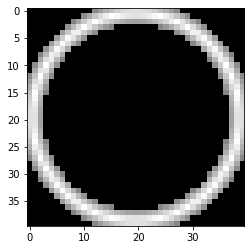

In [13]:
import itertools
import numpy as np
import random as rn
    # size=40 
    # thick = 1
MaxPix = np.max(Image)
MinPix = np.min(Image)

def getKernel( size, thick = 1. ):
    radius = size //2-1
    center = np.array([size/2-.5,size/2-.5])
    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    #ring mask
    ring = np.ones((size,size), dtype=np.float32) #np.random.rand(size,size)
    # print(selectedVecs.T[2])
    # print(np.max(selectedVecs.T[2]))
    maxMask= np.max(selectedVecs.T[2])
    ring = -(ring - MinPix)/(MaxPix-MinPix)
    
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]=k/maxMask

    return ring
plt.imshow(getKernel(40,2),cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)


###One example of arbitrary ring

Conv value: -0.23938815451312112


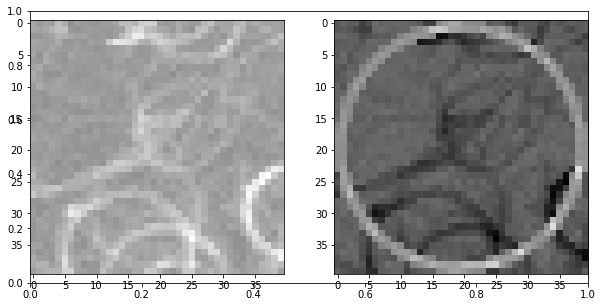

In [14]:
Mask = getKernel( MaxSize, 1 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)

ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('Conv value:',FuzzyCircleConv(square,Mask)/MaxSize**2)


###Some examples of founded ring

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


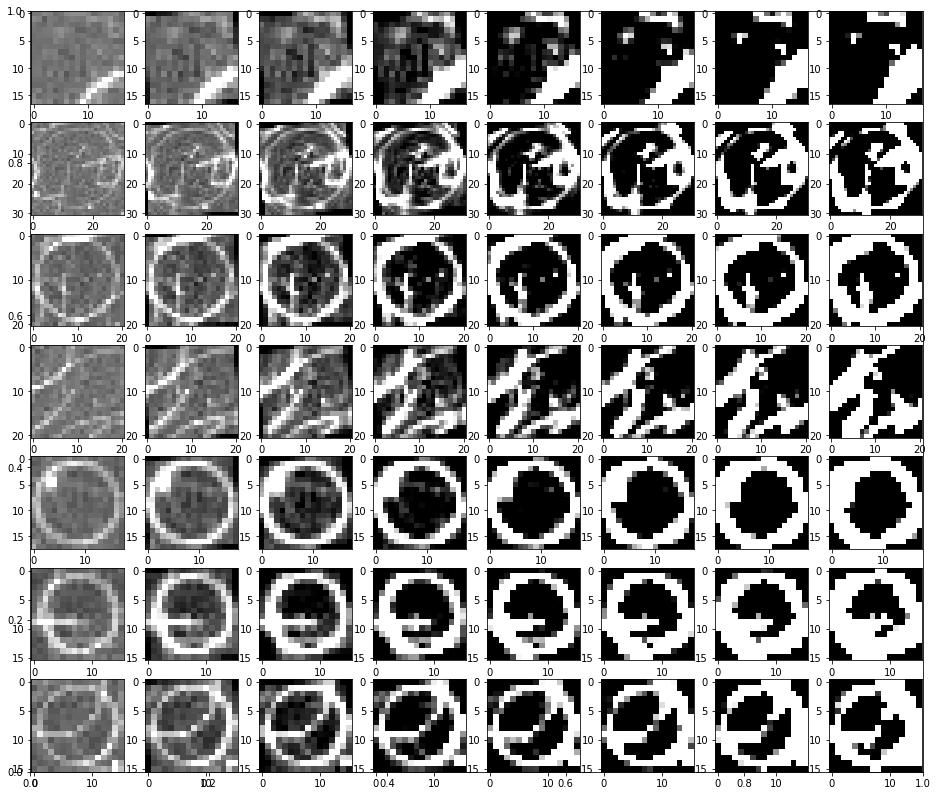

In [15]:
Contrast = 1.8
Variance = 0.03
# data array of some square [size, x, y]
# the first of data is nothing but all other are founded rings
data=np.array([
      [17,348,21,0],
      # [21,1,1,0],
      # [18,168,45,0],
      [31,151,67,1],
      [21,147, 226,1],
      [21,157, 236,1],
      [18, 58, 13,1],
      [16, 133, 50,1],
      [16, 138, 76,1]
      ])
len = data.shape[0]
cnt =8
fig, ax = plt.subplots(figsize=(2*cnt,2*len))
i=1
Thick = 0.8
_angle = 4

for size,x,y,isRing in data:
  Mask = getMask( size, Thick )
  backMask = getMask(size,3*Thick)
  
  #ring visualisation
  box = np.array(Image[y:y+size,x:x+size])
  box = box - np.mean(box) + 1. # normalization to mean = 1
  ax = fig.add_subplot(len,cnt,i)
  ax.imshow(box, cmap=plt.get_cmap('gray'), vmin=0.5, vmax=1.5)
  newbox = np.multiply(box, rotate_image(box,_angle))
  for j in range(1,cnt+1):
    ax1=fig.add_subplot(len,cnt,i+1)
    ax1.imshow(newbox, cmap=plt.get_cmap('gray'), vmin=0.5, vmax=1.5)
    newbox = np.multiply(newbox, rotate_image(newbox,_angle))
    i+=1
    if (i==cnt*len):
      break;

  # ax = fig.add_subplot(len,2,i)
  # ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)    
  # ax1=fig.add_subplot(len,2,i+1)
  # ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
  # ax1.imshow(np.logical_xor(backMask, Mask)  ,alpha=.5)
  # _DEBUG_=True
  # # print('conv value', FuzzyCircleConv(Mask,square)/size**2)
  # found = isCircleFound(square,Mask,backMask)
  # if (isRing):
  #   print('Ring is here, value =', found)
  #   # if (found):
  #   #   print(' AND is found correct')
  #   # else:
  #   #   print(' BUT didn\'t found')
  # else:
  #   print('Ring isn\'t here/ value =', found)
  #   # if (found):
  #   #   print(' BUT is found incorrect')
  #   # else:
  #   #   print(' AND didn\'t found correct')
  # i+=2

fig.show()

_DEBUG_=False


In [16]:
data.shape
len

7

###Try classic convolutions

conv value -0.12937657019172136
-0.12937657019172139


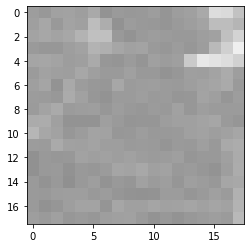

In [17]:
  
  SquareSize=18
  Thick=1
  kernel=getKernel( SquareSize, Thick )
  kernel_size =kernel.shape[0]
  pad_size = kernel_size // 2
  rest = kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = kernel.shape
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  #arbirtary region
  square = sub_matrices[pad_size,pad_size,:,:]
  plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
  print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
  m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)
  # m = np.sum(np.multiply(square))/(kernel_size**2)
  print(m[pad_size,pad_size])  

In [18]:
sub_matrices.shape

(48, 90, 18, 18)

conv value -0.08034258328586487
-0.08034258328586488


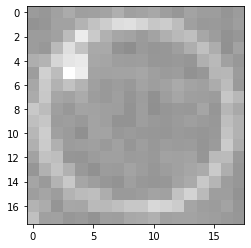

In [19]:
#founded ring
square = sub_matrices[pad_size+13,pad_size+58,:,:]
plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)

print(m[pad_size+13,pad_size+58])

In [20]:
sub_matrices.shape


(48, 90, 18, 18)

In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def conv(_kernel):
  # _kernel = getKernel( size, Thick )
  kernel_size = _kernel.shape[0]
  pad_size = kernel_size // 2
  rest = 0#kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.random.rand(pad_size, ImageSize[1]+pad_size*2)#, dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (_kernel.shape)
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)


  # m=np.sum(np.multiply(sub_matrices,_kernel), axis=(2,3))/(kernel_size**2)
  m = np.einsum('ij,klij->kl',_kernel,sub_matrices)/kernel_size**2
  return m
  

### try masqueraded convolutions

In [0]:
ImageSize=Image.shape

1.1299503041675825
1.1310205211147086
1.21974143014296
1.3210150264017242
1.2726385445276338
1.3380490565357621


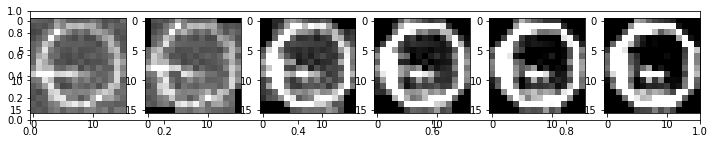

In [27]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
# df = pd.DataFrame(
#     columns=['ID','size','x','y','ring brightness', 'back brightness', 'ring var','full var','back var'],
#     dtype=np.float32
#     )
# def mask_conv(size):
  size=16
  ImageSize=[120,170]
  _angle = np.pi / 18
# def RotateConv(_box,_angle):
  # size = _box.shape[0]
  center = np.array([size//2,size//2],dtype=np.int)
  # matrix transformation prepare
  coords = np.indices((size, size)).reshape(2, -1)
  coords=np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int)
  
  R = np.array([
    [np.cos(_angle), np.sin(_angle), 0],
    [-np.sin(_angle), np.cos(_angle), 0],
    [0, 0, 1]
  ])
  T = np.array([
    [1, 0, center[1]],
    [0, 1, center[0]],
    [0, 0, 1]
  ])
  Rotate_matrix = T @ R @ np.linalg.inv(T)
  
  warp_coords = np.round(Rotate_matrix @ coords).astype(np.int)
  newbox = np.zeros_like(_box)
  xcoord, ycoord = warp_coords[0, :], warp_coords[1, :]
  # Get pixels within image boundary
  indices = np.where((xcoord >= 0) & (xcoord < size) &
                    (ycoord >= 0) & (ycoord < size))
  
  x_new, y_new = xcoord[indices], ycoord[indices]
  x_old, y_old = coords[0][indices], coords[1][indices]
  # ring boolean masks
  (_mask,_backmask)=(getMask( size, .8 ),getMask( size, 2 ))
  background = np.logical_xor(_backmask, _mask)
  mask_size = _mask.shape[0]
  
  # add padding
  # pad_size = mask_size // 2
  # horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  # vertical_pad = np.random.rand(pad_size, ImageSize[1]+pad_size*2)#, dtype=np.float64)
  # a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  # a = np.vstack((vertical_pad, a, vertical_pad))
  a=Image[:ImageSize[0],:ImageSize[1]]
  #make strides
  sub_shape = (_mask.shape)
  view_shape = (ImageSize[0],ImageSize[1], sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)

  #normalisation to mean = 1
  sub_matrices = sub_matrices - np.mean(sub_matrices,axis=(2,3))[:,:,np.newaxis,np.newaxis] + 1.

  new_matrices = np.zeros_like(sub_matrices)
  
  # bias = np.min(sub_matrices,axis=(2,3))
  # bias = bias.reshape(bias.shape + (1,)*(sub_matrices.ndim-2))
  
  brightness = (lambda arr, msk: np.percentile((arr)[:,:,msk],90,axis=2))#/(np.max(arr)-np.min(box))))
  
  #elementwise product all matrices with their rotated copies
  print((brightness(sub_matrices,_mask) / brightness(sub_matrices,background))[50, 133])
  cnt=4
  fig, ax = plt.subplots(figsize=(2*(cnt+2),2))
  
  ax = fig.add_subplot(1,cnt+2,1)
  ax.imshow(sub_matrices[50, 133], cmap=plt.get_cmap('gray'), vmin=0.5, vmax=1.5)
  new_matrices[:,:,y_old,x_old] = sub_matrices[:,:,y_new,x_new]
  
  ax = fig.add_subplot(1,cnt+2,2)
  ax.imshow(new_matrices[50, 133], cmap=plt.get_cmap('gray'), vmin=0.5, vmax=1.5)
  
  print ((brightness(new_matrices,_mask) / brightness(new_matrices,background))[50, 133])
  for i in range(cnt):
    new_matrices[:,:,y_old,x_old] = new_matrices[:,:,y_new,x_new]
    new_matrices=np.multiply(new_matrices, sub_matrices)
    print ((brightness(new_matrices,_mask) / brightness(new_matrices,background))[50, 133])
    ax = fig.add_subplot(1,cnt+2,i+3)
    ax.imshow(new_matrices[50, 133], cmap=plt.get_cmap('gray'), vmin=0.5, vmax=1.5)
  # save to dataframe
  # size_col = np.zeros(ImageSize)
  # size_col.fill(size)

  # df_data = np.array([
  #            size_col.T,
  #            brightness(sub_matrices,_mask).T,
  #            brightness(sub_matrices,background).T,
  #            np.var(sub_matrices[:,:,_mask],axis=-1).T,
  #            np.var(sub_matrices,axis=(-2,-1)).T,
  #            np.var(sub_matrices[:,:,background],axis=-1).T
  # ])

  # y_x=np.array([[[i,j] for j in range(ImageSize[1])] for i in range(ImageSize[0])])
  # df_data= np.concatenate([y_x, df_data.T],axis=-1)
  # axis0 = df_data.shape[0]*df_data.shape[1]
  # return np.reshape(df_data, (axis0,df_data.shape[2]))
  
  # m = (brightness(sub_matrices,_mask) / brightness(sub_matrices,background)) /np.var(sub_matrices[:,:,_mask],axis=-1)
 
  # ['size','x','y','ring brightness', 'back brightness', 'ring var','full var','back var']
 
  # return m
  

In [0]:
print(np.mean(sub_matrices,axis=(2,3))[1,2])
print(sub_matrices[1,2,3,4])
b=np.subtract(sub_matrices,np.mean(sub_matrices,axis=(2,3))[:,:,np.newaxis,np.newaxis])
print(b[1,2,3,4])

## Main loops


In [0]:
import pandas as pd

MinSize=20
MaxSize=40

df = pd.DataFrame(
      columns=['y','x','size','ring brightness', 'back brightness', 'ring var','full var','back var'],
      dtype=np.float32
      )

# ConvMatrices = np.empty((0,ImageSize[0],ImageSize[1]))
for size in range(MinSize,MaxSize):
  #print('size '+str(size))
  new_rows = mask_conv(getMask( size, .8 ),getMask( size, 2 ))

  df = df.append(pd.DataFrame(new_rows))
  # ConvMatrices= np.concatenate((ConvMatrices, np.reshape(res,(1,ImageSize[0],ImageSize[1]))),axis=0)

In [0]:
df.to_csv('df_coffieCircles.csv')

In [0]:

for size,x,y,_ in data:
  res= df.loc[(df.size==size) & (df.x==x) & df.y==y]
  print (res)
  #print(ConvMatrices[size-MinSize,y+size//2,x+size//2])    


In [0]:
print(ConvMatrices.shape)

In [0]:
# outfile = TemporaryFile()
np.save('ConvMatrices', ConvMatrices)

###Loop of masqueraded convolutions


In [0]:


Contrast=0.17
import matplotlib.patches as patches
# plt.ioff()
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(Image,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch

cnt=0
for size in range(MinSize,MaxSize):
  print('size: ',size)
  convs = ConvMatrices[size-MinSize,size//2:-size//2,size//2:-size//2]
  for i in range(size//2,convs.shape[0]-size//2):
    y= i 
    for j in range(size//2, convs.shape[1]-size//2):
      x = j 
      if (convs[i,j]>170):
        rect = patches.Rectangle((x,y),size,size,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        lbl = str(size)+':'+str(x)+':'+str(y)
        ax.text(x,y, lbl,
          color='red')
        # plt.text(x,y,lbl,facecolor='r')
        #print(x, y, convs[i,j])
        cnt+=1
      if (cnt>60):
        break
    else:
      continue
    break
  else:
    continue
  break

plt.show()